# STATS 507 Final Project

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

## Load and describe the dataset

In [16]:
def load_dataset(path_or_url):
    """Load the diabetes dataset from a CSV file or URL into a pandas DataFrame."""
    try:
        df = pd.read_csv(path_or_url)
    except Exception as e:
        raise FileNotFoundError(f"Could not load dataset from {path_or_url}") from e
    return df

In [17]:
data_url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = load_dataset(data_url)
print("Dataset loaded. Shape:", df.shape)

Dataset loaded. Shape: (768, 9)


In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
print("Class distribution:\n", df["Outcome"].value_counts(), "\n")

Class distribution:
 0    500
1    268
Name: Outcome, dtype: int64 



In [20]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Preprocess the data

In [21]:
def preprocess_data(df):
    """Handle missing values and scale features for the diabetes dataset."""
    # Replace zero values in certain columns with NaN
    cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    for col in cols_with_missing:
        df[col] = df[col].replace(0, np.nan)
    # Fill missing values with the median of each column
    df.fillna(df.median(numeric_only=True), inplace=True)

    X = df.drop("Outcome", axis=1)
    y = df["Outcome"]
    # Scale features to have mean 0 and unit variance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X, y

In [22]:
X, y = preprocess_data(df)
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

Training samples: 614, Testing samples: 154


## Train models

In [23]:
def train_models(X_train, y_train):
    """Train SVM, XGBoost, and Logistic Regression models on the training data."""
    models = {}
    models["SVM"] = SVC(kernel='rbf', probability=True, random_state=42)
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    models["LogisticRegression"] = LogisticRegression(max_iter=500, random_state=42)

    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

In [24]:
models = train_models(X_train, y_train)

/Users/slinling/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:23:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Evaluate models on the test set

In [25]:
def evaluate_model(model, X_test, y_test):
    """Evaluate a trained model on the test set and return performance metrics."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1 for ROC AUC

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return accuracy, precision, recall, f1, auc

In [26]:
print("\nPerformance on test set:")
for name, model in models.items():
    acc, prec, rec, f1, auc = evaluate_model(model, X_test, y_test)
    print(f"{name}: Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, F1-score={f1:.3f}, ROC AUC={auc:.3f}")


Performance on test set:
SVM: Accuracy=0.734, Precision=0.644, Recall=0.537, F1-score=0.586, ROC AUC=0.796
XGBoost: Accuracy=0.766, Precision=0.680, Recall=0.630, F1-score=0.654, ROC AUC=0.820
LogisticRegression: Accuracy=0.708, Precision=0.600, Recall=0.500, F1-score=0.545, ROC AUC=0.813


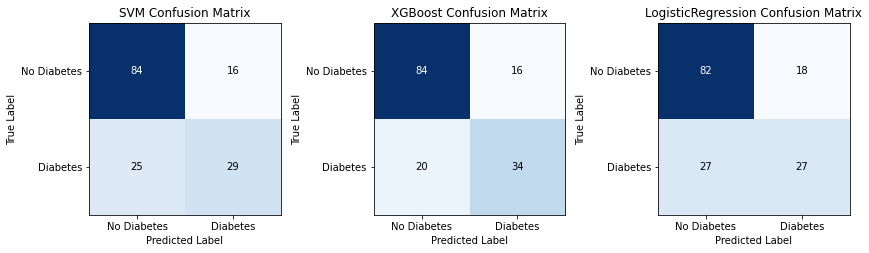

In [27]:
fig, axes = plt.subplots(1, len(models), figsize=(12, 4))
for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['No Diabetes', 'Diabetes'])
    ax.set_yticklabels(['No Diabetes', 'Diabetes'])
    # Annotate the confusion matrix cells with counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.savefig('fig1.png', dpi=300)
plt.show()

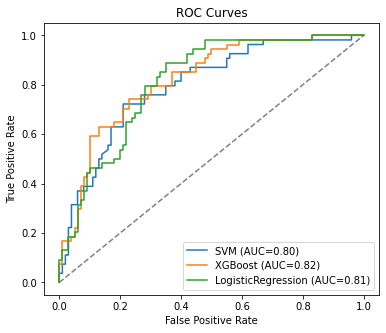

In [28]:
plt.figure(figsize=(6,5))
for name, model in models.items():
    # Get true positive rate and false positive rate for various thresholds
    y_prob = model.predict_proba(X_test)[:, 1]
    # Compute ROC curve points
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
# Plot the random chance line
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.savefig('fig2.png', dpi=300)
plt.show()